# Keilegavlen et. al. (2017) mechanics experiment
This notebook will reproduce the Numerical Experiment provided in Keilegavlen et. al. (2017).

## Numerical setup
Consider a unit square with a heterogenity in the upper right corner, defined by
\begin{equation}
\chi_{2D} (x,y) =
\begin{cases}
1, \quad \min (x,y) > 1/2 \\
0, \quad \text{otherwise}
\end{cases}
\end{equation}
The material parameters are the following: $\mu = (1 - \chi_{2D}) + \kappa \chi_{2D}$ and $\lambda = \alpha \mu$. \
In this case, higher values of $\alpha$ implies a more incompressible material. \
The paper presents the analytical solution as

\begin{equation}
\boldsymbol{u} (x,y) =
\begin{bmatrix}
(x-0.5)^2 (y-0.5)^2 \\
-\frac{2}{3} (x-0.5)(y-0.5)^3
\end{bmatrix}
/ ((1 - \chi_{2D}) + \kappa \chi_{2D})
\end{equation}

Furthermore, in the solution shown in Figure 3, $\kappa = 1$.

## Code setup

In [1]:
import porepy as pp
import scipy.sparse as sps
import numpy as np

Define parameters

In [2]:
def chi(x,y):
    if min(x,y) > 1/2:
        return 1
    return 0

def kappa():
    return 2

def Mu(x,y):
    return (1-chi(x,y)) + kappa()*chi(x,y)
    #return 1 + chi(x,y)*(kappa()-1)

def Lam(x,y, alpha=1):
    return alpha * Mu(x,y)

Define analytical solution

In [3]:
def uexact(x,y):
    den = 1 - chi(x,y) + kappa() * chi(x,y)
    
    ux = ((x-0.5)**2 * (y-0.5)**2) / den
    uy = (-(2/3) * (x-0.5) * (y-0.5)**3) / den
    
    return np.array((ux,uy))

Create grid \
By the visualization, we should have 8 cells in each direction.

In [4]:
n = 8
physdims = [1,1]
g = pp.CartGrid([n,n], physdims=physdims)
g.compute_geometry()

Next, compute $\mu$ and $\lambda$ in each cell.

In [5]:
cell_centers_2D = g.cell_centers.T[:,:2]
mu = np.array([Mu(*x) for x in cell_centers_2D])
lam = np.array([Lam(*x) for x in cell_centers_2D])

Compute the stiffness matrix

In [6]:
C = pp.FourthOrderTensor(mu, lam)

Boundary conditions. \
According to the paper, boundary conditions are determined by the analytical solution.

In [7]:
# Boundary type
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
labels = np.array(['dir']*b_faces.size)

bc = pp.BoundaryConditionVectorial(g, b_faces, labels)

# Boundary values
bc_val = np.zeros((g.dim, g.num_faces))
face_centers = g.face_centers.T[:,:2][b_faces]
bc_val[:, b_faces] = np.array([uexact(*x) for x in face_centers]).T
bc_val = bc_val # * g.face_areas 
bc_val = bc_val.ravel('F')

Body forces. \
According to the paper, "the body force [...] is found by taking the divergence of the stress".

In [8]:
# Try first f = 0.
f = np.zeros(g.dim * g.num_cells)

# Compute the analytical divergence:

def grad_u(x,y):
    ii = 2*(x-0.5) * (y-0.5)**2
    xy = 2*(x-0.5)**2 * (y-0.5)
    yx = -(2/3) * (y-0.5)**3
    return np.array([[ii, yx], [xy, -ii]])


def Strain(x,y):
    return (grad_u(x,y) + grad_u(x,y).T)/2


def Stress(x,y):
    strn = Strain(x,y)
    return 2 * Mu(x,y) * strn + Lam(x,y) * np.trace(strn) * np.eye(strn.shape[0])

In [9]:
div = pp.fvutils.vector_divergence(g)
stress_exact = np.array([Stress(*x) for x in cell_centers_2D])
#f = div * stress_exact

In [10]:
div.shape

(128, 288)

In [11]:
stress_exact.shape

(64, 2, 2)

In [12]:
stress_exact

array([[[-3.34960938e-01, -1.11653646e-01],
        [-1.11653646e-01,  3.34960938e-01]],

       [[-2.39257812e-01, -2.96223958e-02],
        [-2.96223958e-02,  2.39257812e-01]],

       [[-1.43554688e-01,  2.50651042e-02],
        [ 2.50651042e-02,  1.43554688e-01]],

       [[-4.78515625e-02,  5.24088542e-02],
        [ 5.24088542e-02,  4.78515625e-02]],

       [[ 4.78515625e-02,  5.24088542e-02],
        [ 5.24088542e-02, -4.78515625e-02]],

       [[ 1.43554688e-01,  2.50651042e-02],
        [ 2.50651042e-02, -1.43554688e-01]],

       [[ 2.39257812e-01, -2.96223958e-02],
        [-2.96223958e-02, -2.39257812e-01]],

       [[ 3.34960938e-01, -1.11653646e-01],
        [-1.11653646e-01, -3.34960938e-01]],

       [[-1.70898438e-01, -9.92838542e-02],
        [-9.92838542e-02,  1.70898438e-01]],

       [[-1.22070312e-01, -4.06901042e-02],
        [-4.06901042e-02,  1.22070312e-01]],

       [[-7.32421875e-02, -1.62760417e-03],
        [-1.62760417e-03,  7.32421875e-02]],

       [[-

Discretize and solve the system

In [13]:
mpsa = pp.Mpsa('mechanics')

specified_parameters = {'fourth_order_tensor': C, 'source': f, 'bc': bc, 'bc_values': bc_val}
data = pp.initialize_default_data(g, {}, 'mechanics', specified_parameters)
mpsa.discretize(g, data)
A, b = mpsa.assemble_matrix_rhs(g, data)

u = sps.linalg.spsolve(A, b)


Verify the solution. \
In PorePy, u is ordered like $u = [u_{x_0}, u_{y_0}, u_{x_1}, u_{y_1}, u_{x_2}, u_{y_2}, ...]$

In [14]:
u.shape

(128,)

In [15]:
u_2d = np.reshape(u, (g.dim, -1), order='F')
u_2dT = u_2d.T

In [16]:
u_exact_2d = np.array([uexact(*x) for x in g.cell_centers.T[:,:2]])

In [17]:
(u_2dT - u_exact_2d)/u_exact_2d

array([[ 6.43234093e-02,  9.17366774e-02],
       [ 2.43122486e-01,  9.15396744e-02],
       [ 7.96559572e-01,  1.00674487e-01],
       [ 7.49716456e+00,  1.13096519e-01],
       [ 7.50557376e+00,  8.85607133e-02],
       [ 7.99233454e-01,  9.35536363e-02],
       [ 2.44377034e-01,  8.86516200e-02],
       [ 6.46779030e-02,  9.10298240e-02],
       [ 1.29120306e-01,  4.07758291e-01],
       [ 5.13451798e-01,  5.09305235e-01],
       [ 1.73219920e+00,  5.62003215e-01],
       [ 1.64366018e+01,  6.48147554e-01],
       [ 1.64497448e+01,  4.40346027e-01],
       [ 1.73726933e+00,  5.01222609e-01],
       [ 5.16317349e-01,  4.85047118e-01],
       [ 1.30079424e-01,  4.02171289e-01],
       [ 3.14182811e-01,  1.52371048e+00],
       [ 1.10496376e+00,  2.13424377e+00],
       [ 3.50127240e+00,  2.44218646e+00],
       [ 3.21198883e+01,  3.04515740e+00],
       [ 3.19823690e+01,  1.44712437e+00],
       [ 3.46640093e+00,  1.95902600e+00],
       [ 1.09339012e+00,  1.93516525e+00],
       [ 3.

Extract the traction on the faces

In [18]:
matrix_dictionary = data[pp.DISCRETIZATION_MATRICES]['mechanics']
stress = matrix_dictionary["stress"]
bound_stress = matrix_dictionary["bound_stress"]

In [19]:
stress.shape

(288, 128)

In [20]:
T = stress * u + bound_stress * bc_val
T2d = np.reshape(T, (g.dim, -1), order='F')
u_b2d = np.reshape(bc_val, (g.dim, -1), order='F')

/home/haakon/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


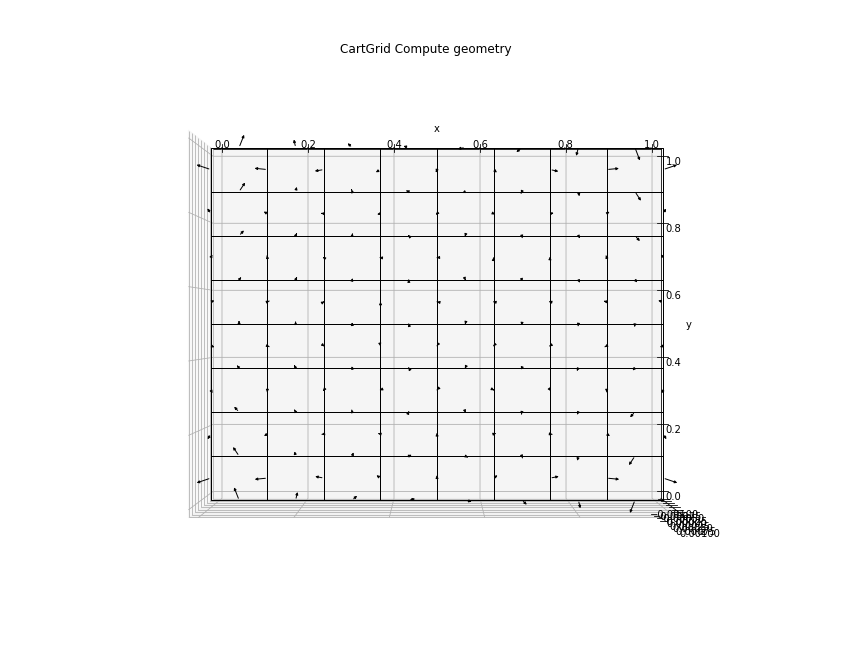

In [21]:
T = np.vstack((T2d, np.zeros(g.num_faces)))
pp.plot_grid(g, vector_value=T, figsize=(15, 12), alpha=0)

[0, 1, 0, 1]

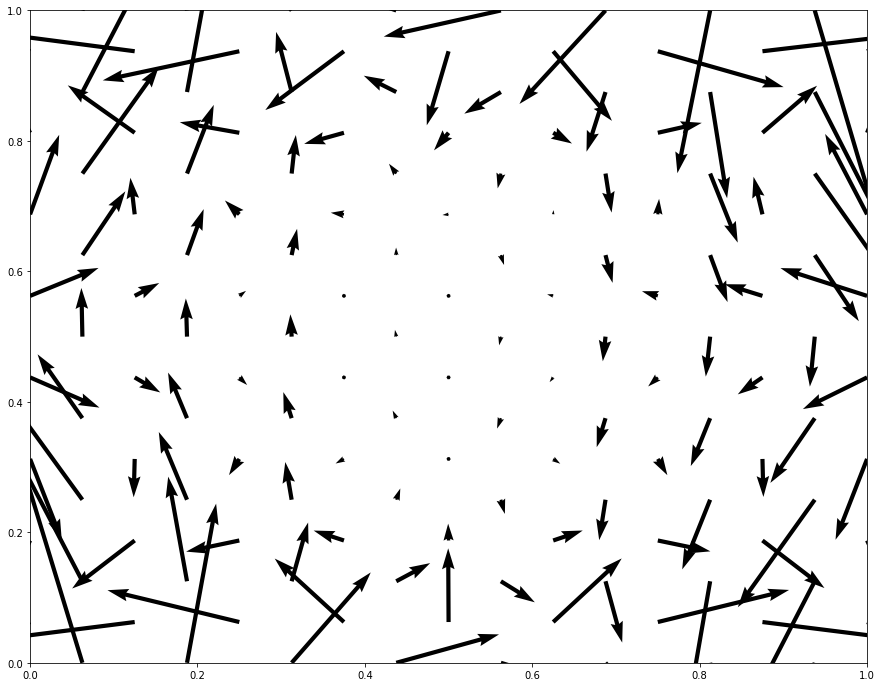

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,12))

x_pos = g.face_centers[0]
y_pos = g.face_centers[1]
ux = T2d[0]
uy = T2d[1]

ax.quiver(x_pos,y_pos,ux,uy, scale=.15)
ax.axis([0,1,0,1])

In [23]:
div = pp.fvutils.vector_divergence(g)

In [24]:
body_forces = div * stress * u + div * bound_stress * bc_val

In [25]:
(stress*u).shape

(288,)

In [26]:
stress.shape

(288, 128)

In [27]:
u.shape

(128,)

Compute the ana